In [1]:
%pip install nnfs

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib notebook
%matplotlib inline
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
import torch.nn as nn
from torch.nn import functional as F
import pprint as pp
import seaborn as sns
import pandas as pd
from nnfs.datasets import spiral_data
import nnfs

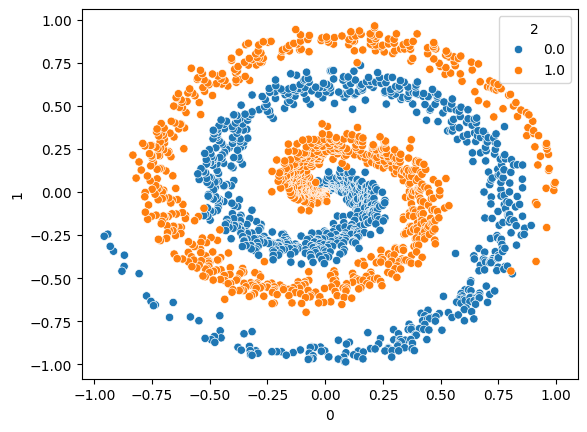

In [77]:
n_classes = 2

X, y = spiral_data(samples=1000, classes=n_classes)  # y is the class assignments
df = pd.DataFrame(np.append(X, y.reshape(-1, 1), axis=1))
sns.scatterplot(data=df, x=df.iloc[:, 0], y=df.iloc[:, 1], hue=df.iloc[:, 2])
plt.show();

In [78]:
def split_data(X, y, test_size=0.2):
    n_test = int(len(y) * test_size)
    indexes = torch.randperm(len(y))
    X_test = X[indexes[:n_test]]
    y_test = y[indexes[:n_test]]
    X_train = X[indexes[n_test:]]
    y_train = y[indexes[n_test:]]
    return X_train, X_test, y_train, y_test

In [79]:
Xtr, Xval, Ytr, Yval = split_data(X, y)

Let's try building a classifier

In [101]:
from collections import OrderedDict

class SpiralNet(nn.Module):
    def __init__(self, activation, n_in, n_hidden, n_out):
        super().__init__()
        self.losses = []
        self.activation = nn.ReLU() if activation == 'relu' else nn.Sigmoid()

        self.layers = nn.Sequential(
            OrderedDict([
                ('h1', nn.Linear(n_in, n_hidden)),
                ('act1', self.activation),
                ('h2', nn.Linear(n_hidden, n_hidden)),
                ('act2', self.activation),
                ('h3', nn.Linear(n_hidden, n_hidden)),
                ('act3', self.activation),
                ('h4', nn.Linear(n_hidden, n_hidden)),
                ('act4', self.activation),
                ('head', nn.Linear(n_hidden, n_out)),
            ])
        )

        # self.loss = nn.CrossEntropyLoss()

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        return self.layers(X)

    def train(self, X, y, epochs: int=1000):
        X = torch.FloatTensor(X)
        y = torch.Tensor(y).type(torch.LongTensor)

        for epoch in range(epochs):
            logits = self(X)
            loss = F.cross_entropy(logits, y)
            self.losses.append(loss.item())

            self.optimizer.zero_grad()  # clear gradients
            loss.backward()             # update gradients
            self.optimizer.step()       # update weights

    def predict(self, X):
        X = torch.FloatTensor(X)
        logits = self.forward(X)
        probs = F.softmax(logits, dim=1)
        return torch.argmax(probs, dim=1)

    def evaluate(self, X, y):
        X = torch.FloatTensor(X)
        y = torch.Tensor(y).type(torch.LongTensor)

        preds = self.predict(X)
        acc = (preds == y).sum().item() / len(y)
        return acc

In [111]:
model = SpiralNet(activation='sigmoid', n_in=2, n_hidden=3, n_out=n_classes)

Loss:                0.179759
Training Accuracy:   0.897500
Validation Accuracy: 0.857500


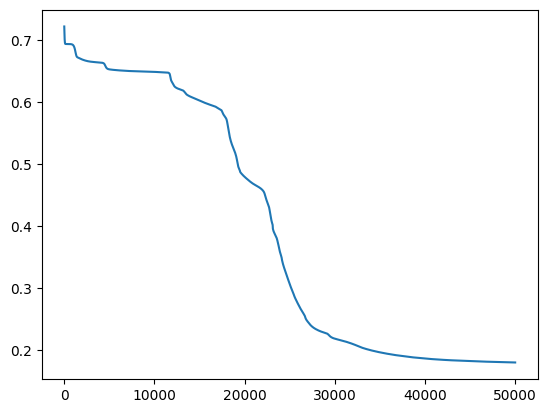

In [112]:
model.train(Xtr, Ytr, epochs=50000)
print(f'Loss:                {model.losses[-1]:,.6f}')
print(f'Training Accuracy:   {model.evaluate(Xtr, Ytr):,.6f}')
print(f'Validation Accuracy: {model.evaluate(Xval, Yval):,.6f}')
plt.plot(model.losses)
plt.show();

class 0 -- true: 198, pred: 199, diff: -1
class 1 -- true: 202, pred: 201, diff: 1
class 2 -- true: 0, pred: 0, diff: 0


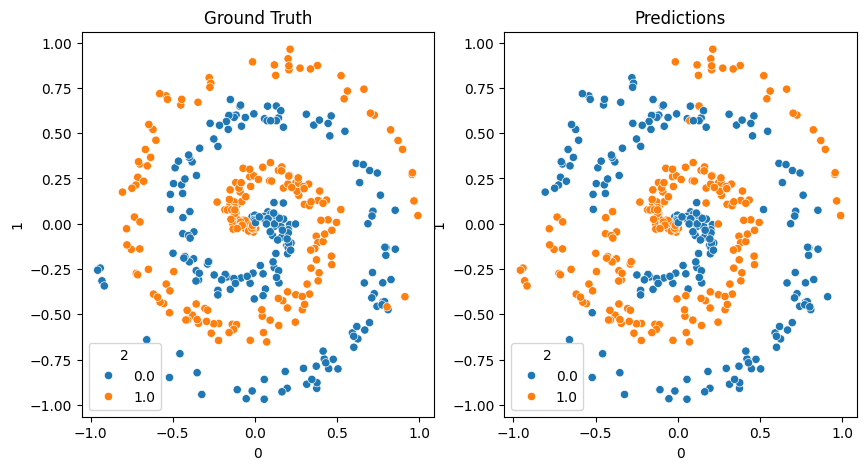

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

df1 = pd.DataFrame(np.append(Xval, Yval.reshape(-1, 1), axis=1))
sns.scatterplot(data=df1, x=df1.iloc[:, 0], y=df1.iloc[:, 1], hue=df1.iloc[:, 2], ax=ax1)
ax1.set_title('Ground Truth')

preds = model.predict(Xval).numpy()
df2 = pd.DataFrame(np.append(Xval, preds.reshape(-1, 1), axis=1))
sns.scatterplot(data=df2, x=df2.iloc[:, 0], y=df2.iloc[:, 1], hue=df2.iloc[:, 2], ax=ax2)
ax2.set_title('Predictions')

print(f'class 0 -- true: {(Yval == 0).sum()}, pred: {(preds == 0).sum()}, diff: {(Yval == 0).sum() - (preds == 0).sum()}')
print(f'class 1 -- true: {(Yval == 1).sum()}, pred: {(preds == 1).sum()}, diff: {(Yval == 1).sum() - (preds == 1).sum()}')
print(f'class 2 -- true: {(Yval == 2).sum()}, pred: {(preds == 2).sum()}, diff: {(Yval == 2).sum() - (preds == 2).sum()}')

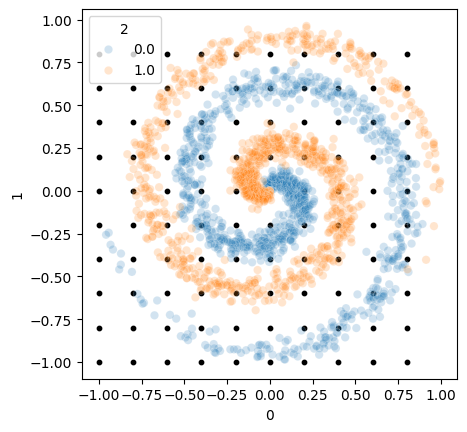

In [116]:
x1, x2 = np.arange(-1, 1, 0.2), np.arange(-1, 1, 0.2)


def plot_grid(x1, x2, df):
  X, Y = np.meshgrid(x1, x2)
  fig, ax = plt.subplots()
  ax.scatter(X, Y, s=10, color='black')
  sns.scatterplot(data=df, x=df.iloc[:, 0], y=df.iloc[:, 1], hue=df.iloc[:, 2], ax=ax, alpha=0.2)
  ax.set_aspect('equal')
  plt.show();

plot_grid(x1, x2, df)

In [124]:
Xg = torch.tensor(np.stack((x1, x2)).T).float()
model.layers[0](Xg)

tensor([[-6.0299,  7.6996, -4.8224],
        [-4.1788,  6.3934, -3.2594],
        [-2.3277,  5.0871, -1.6965],
        [-0.4766,  3.7808, -0.1335],
        [ 1.3745,  2.4746,  1.4294],
        [ 3.2256,  1.1683,  2.9924],
        [ 5.0767, -0.1380,  4.5553],
        [ 6.9279, -1.4442,  6.1182],
        [ 8.7790, -2.7505,  7.6812],
        [10.6301, -4.0568,  9.2441]], grad_fn=<AddmmBackward0>)

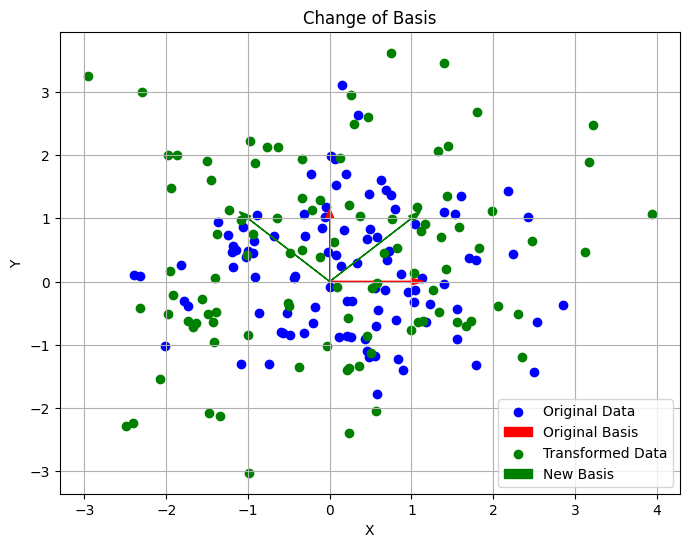

In [49]:
# apply first affine transformation
plot_grid(x1, x2, df2)

In [ ]:
from sklearn.metrics import accuracy_score
print('Training Accuracy:   ', model.evaluate(Xtr, Ytr), accuracy_score(Ytr, model.predict(Xtr)))
print('Validation Accuracy: ', model.evaluate(Xval, Yval), accuracy_score(Yval, model.predict(Xval)))

Training Accuracy:    0.9875 0.9875
Validation Accuracy:  0.8166666666666667 0.8166666666666667


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
boost = HistGradientBoostingClassifier(
    learning_rate = 0.1,
    max_depth = None,
    max_iter = 1000,
    max_leaf_nodes = 10,
    min_samples_leaf = 10,
)
boost.fit(Xtr, Ytr)
boost.score(Xval, Yval)

0.7